In [1]:
import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, NUTS, HMC
from pyro.optim import Adam
from pyro.infer import EmpiricalMarginal, TracePredictive, SVI, Trace_ELBO

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn")

In [2]:
count_data = torch.tensor(np.loadtxt("./data/txtdata.csv"))
n_count_data = len(count_data)

(0, 74)

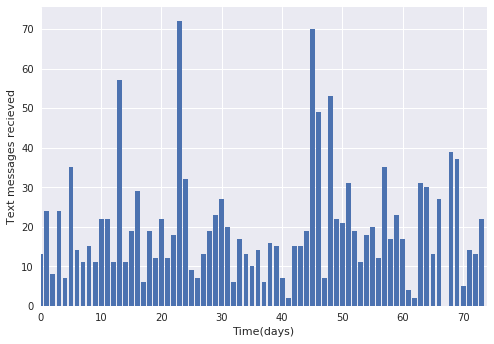

In [3]:
plt.bar(np.arange(n_count_data),count_data)
plt.ylabel("Text messages recieved")
plt.xlabel("Time(days)")
plt.xlim(0,n_count_data)

変化点はあるだろうか？    
変化点を見つけるためにベイズ的にモデリングをしようと思う。   
まず、1日あたりに受信するメッセージの分布がある時を境に変化したと考える。   

In [4]:
def lambda_(tau, lambda1, lambda2):
    out = torch.zeros(n_count_data)
    index = int(tau.data.numpy())
    out[:index] = lambda1
    out[index:] = lambda2
    return out

def model(data):
    data = count_data.clone()
    alpha = (1. / data.mean())
    lambda1 = pyro.sample("lambda1", dist.Exponential(rate=alpha))
    lambda2 = pyro.sample("lambda2", dist.Exponential(rate=alpha))
#     tau = pyro.sample("tau", dist.Uniform(0, 1))
#     lambda1_size = int(tau.item() * data.size(0)) + 1
#     lambda2_size = data.size(0) - lambda1_size
#     lambda_ = torch.cat([lambda1.expand((lambda1_size,)), lambda2.expand((lambda2_size,))])
    tau = pyro.sample("tau", dist.Uniform(0,n_count_data))
#     lambda_ = torch.cat([lambda1.expand([tau.item()]),
#                          lambda2.expand([n_count_data-tau.item()])])
# #     ##for NUTS##
    obs = pyro.sample("obs",dist.Poisson(lambda_(tau,lambda1,lambda2)),obs=data)
    return obs
    
    ##ELBO##
#     for i in range(len(data)):
#         pyro.sample("obs_{}".format(i), 
#                          dist.Poisson(lambda_[i]),obs=data[i])
# #     with pyro.plate("data_plate", len(data)):
#         pyro.sample("obs", dist.Poisson(lambda_))
    
#     lambda_ = torch.gather(torch.tensor([lambda1, lambda2]), 0,
#               (tau <= torch.arange(len(data)).float()).long())
#     lambda_ = torch.gather(torch.tensor([lambda1, lambda2]), 0,
#                            tau <= torch.arange(len(data)))
#     for i in range(len(data)):
#         if (i < tau.data.numpy()[0]):
#             pyro.observe("obs_{0}".format(i), dist.Poisson(lambda1), obs=data[i])
#         else:
#             pyro.sample("obs_{0}".format(i), dist.Poisson(lambda2), obs=data[i]) 
#     with pyro.plate("data_plate", len(data)):
# #         pyro.sample("obs", dist.Poisson(lambda_),obs=data)
# #         
        
def guide(data):
    pyro.sample("tau", dist.Categorical(torch.tensor(np.full(n_count_data,1/n_count_data))))

    m1 = pyro.param("m1", torch.tensor(0.0))
    s1 = pyro.param("s1", torch.tensor(1.0),
                      constraint=constraints.positive)
    pyro.sample("lambda_1", dist.Normal(m1, s1))
    m2 = pyro.param("m2", torch.tensor(0.0))
    s2 = pyro.param("s2", torch.tensor(1.0),
                      constraint=constraints.positive)
    pyro.sample("lambda_2", dist.Normal(m2, s2))
    
#     m3 = pyro.param("m3", torch.tensor(0.0))
#     s3 = pyro.param("s3", torch.tensor(1.0),
#                       constraint=constraints.positive)
#     pyro.sample("tau", dist.Normal(m3, s3))

In [5]:
pyro.clear_param_store()
nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, num_samples=600, warmup_steps=100)
mcmc_run.run(count_data)

Sample: 100%|██████████| 700/700 [13:59,  1.20s/it, step size=7.87e-03, acc. prob=0.560]


In [6]:
mcmc_run.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   lambda1     20.09      0.49     20.08     19.17     20.81    127.75      1.01
   lambda2     13.99      2.34     13.59     10.26     16.92     93.84      1.01
       tau     70.56      0.62     70.53     70.00     70.98     81.56      1.01

Number of divergences: 0


In [7]:
tau_samples = mcmc_run.get_samples()['tau']
lambda1_samples = mcmc_run.get_samples()['lambda1']
lambda2_samples = mcmc_run.get_samples()['lambda2']
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    ix = tau_samples > day
    expected_texts_per_day[day] = (lambda1_samples[ix].sum()+ lambda2_samples[~ix].sum()) / N

<BarContainer object of 74 artists>

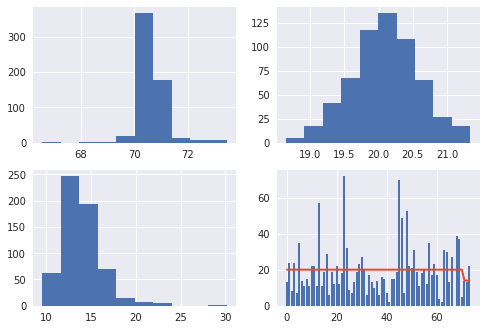

In [8]:
fig = plt.figure()
ax = fig.add_subplot(221)
ax.hist(mcmc_run.get_samples()['tau'])
ax = fig.add_subplot(222)
ax.hist(mcmc_run.get_samples()['lambda1'])
ax = fig.add_subplot(223)
ax.hist(mcmc_run.get_samples()['lambda2'])
ax = fig.add_subplot(224)
ax.plot(np.arange(0,n_count_data,1), expected_texts_per_day, lw=2, color="#E24A33",
         label="expected number of text-messages received")
plt.bar(np.arange(n_count_data),count_data)